In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.raster_tools import Raster_profile 
import matplotlib.pyplot as plt

## Read and find the coverage area of a theos satellite image  

In [2]:
theos_image_file = os.path.join("data","TH2_PATTYA","MS_L3", "T2_PRO_ISP202601210212020704_20260121021522796_2", "VOL_T2V_ORTHO_DS_T2V_202501190343234_VXB_E101N13_007823_32", "IMG_T2V_ORTHO_MS_32", "IMG_T2V_20250119034323_ORTHO_MS_32.TIF")
thoes_Profile = Raster_profile(theos_image_file) 

Dataset name: data/TH2_PATTYA/MS_L3/T2_PRO_ISP202601210212020704_20260121021522796_2/VOL_T2V_ORTHO_DS_T2V_202501190343234_VXB_E101N13_007823_32/IMG_T2V_ORTHO_MS_32/IMG_T2V_20250119034323_ORTHO_MS_32.TIF
File mode: r
Number of bands: 4
Image width: 6458 pixels
Image height: 6340 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 6340, 6458)
Data type: uint16


In [3]:
long_start, lat_start= thoes_Profile.get_longlat_from_image_pixels(0, 0, crs_dst="EPSG:4326")

In [4]:
long_end, lat_end = thoes_Profile.get_longlat_from_image_pixels(6458, 6340, crs_dst="EPSG:4326")

In [5]:
raster = thoes_Profile.raster
raster_HWC = thoes_Profile.convert_CHW_to_HWC(raster)
raster_HWC = raster_HWC[:,:,:3]
raster_HWC = thoes_Profile.image_enhancement(raster_HWC)


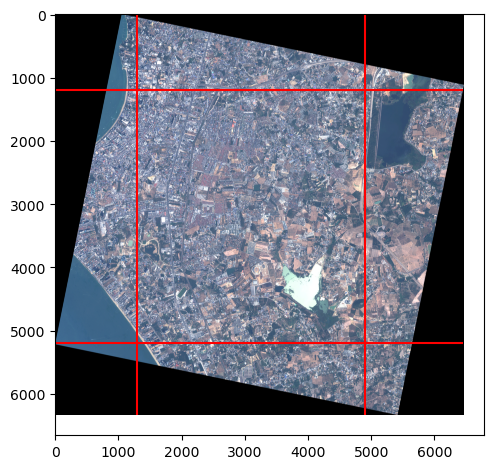

In [6]:
plt.imshow(raster_HWC)
plt.hlines(y=1200, xmin=0, xmax=6458, colors="r") 
plt.hlines(y=5200, xmin=0, xmax=6458, colors="r")
plt.vlines(x=1300, ymin=0, ymax=6340, colors="r") 
plt.vlines(x=4900, ymin=0, ymax=6340, colors="r")  
plt.tight_layout()
plt.savefig("satellite_area_selection.png")

## Select the coordinates

In [7]:
x_start = 1300
y_start = 1200

x_end = 4900
y_end = 5200

bbox = [x_start, y_start, x_end, y_end] 
coordinates = [
    [bbox[0], bbox[3]],  # Top-left corner (min_lon, max_lat)
    [bbox[2], bbox[3]],  # Top-right corner (max_lon, max_lat)
    [bbox[2], bbox[1]],  # Bottom-right corner (max_lon, min_lat)
    [bbox[0], bbox[1]],  # Bottom-left corner (min_lon, min_lat)
    [bbox[0], bbox[3]]   # Closing the polygon by repeating the first point
    ]

poly_gons = []
for coord in coordinates: 
    easting, northing = thoes_Profile.get_longlat_from_image_pixels(coord[0], coord[1], crs_dst="EPSG:32647")
    poly_gons.append([easting, northing])

### Crop image and save tiff

In [8]:
clipped_theos_file = "theos/clipped_T2_PRO_ISP202601210212020704.tif" 
leafmap.clip_image(theos_image_file, poly_gons, clipped_theos_file)

Reading input: /mnt/HDD2/GISTDA_workspace/geo/Building_detection/theos/clipped_T2_PRO_ISP202601210212020704.tif

Adding overviews...
Updating dataset tags...
Writing output to: /mnt/HDD2/GISTDA_workspace/geo/Building_detection/theos/clipped_T2_PRO_ISP202601210212020704.tif


### See the result

In [9]:
clipped_theos_file = "theos/clipped_T2_PRO_ISP202601210212020704.tif"

m = leafmap.Map(center=[(lat_start + lat_end)/2, (long_start + long_end)/2], zoom=16, height="800px")
m.add_basemap("Satellite") 
m.add_raster(clipped_theos_file, layer_name="Theos") 
m

Map(center=[12.908807, 100.922147], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Clip the Google image